In [38]:
from pathlib import Path

In [39]:
folder = Path(r"outputs\2025_12_6-0_53_54\01\0.70\2017")
it = 1
graph_root = np.array([0, 1])

In [40]:
w_map = cv2.imread(folder / f"skeleton/iter_{it}.jpg")[..., 0] / 255 * 5
mask = cv2.imread(folder / f"strong/iter_{it}.jpg")[..., 0] / 255

In [41]:
w_pts = np.array(np.where((w_map > 0.1) * (w_map < 5))).T
# print("Skeleton size:", w_pts.shape[0])
if w_pts.shape[0] > 4000:
    print("Mask dilated too much")

dist = np.linalg.norm(w_pts - graph_root, axis=1)
nn = w_pts[np.argmin(dist)]

In [42]:
nn

array([ 1, 14])

In [ ]:
directions = np.array([(-1, 0),(-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1)]) 
def unilateral_dfs_tree(g_mask, inp_mask, start, b_mask = None, alpha=0.1, thresh=0.95, context_size=3, dis_map=None, tolerance=-0.5):
    h, w = inp_mask.shape
    global directions
    rows, cols = g_mask.shape[:2]
    stack = PriorityQueue()
    # Dijikstra
    status = np.zeros(g_mask.shape, dtype=int)

    # This to indicate strictly incremental path
    g_mask = np.abs(g_mask - 0.001)
    cost = np.full_like(g_mask, 1e4)
    px, py = start
    if dis_map is not None:
        stack.put((0, 0, (dis_map[px, py][None, :], start)))
    else: 
        stack.put((0, 0, (np.zeros(1, 2), start)))
    cost[px, py] = 0
    leaves = set()
    border = set()
    begin = start
    parent = {}
    dead = set()
    dfs_tree = defaultdict(list)
    i = 0
    while not stack.empty():
        state, _, (moves, (x, y)) = stack.get()
        # print(moves, x, y)
        prior = np.mean(moves, axis=0)
        dis_map[x, y] = (prior + dis_map[x, y]) / 2
        # print(dis_map[x, y])
        valid = (directions * dis_map[x, y]).sum(axis=1)
        score = np.abs(valid).tolist()
        indexes = [index for index, s in sorted(enumerate(score), key= lambda x: x[1]) if valid[index] >= tolerance]
        accepted_dir = [directions[i] for i in indexes]
        scores = [score[i] for i in indexes]
        # print(accepted_dir)
        for di in accepted_dir:
            (dx, dy) = di.tolist()
            if moves.shape[0] >= context_size: 
                moves = moves[1:].copy()
            di_state = np.concatenate([moves, np.array([(dx, dy)])], axis=0)
            
            nx, ny = x + dx, y + dy
            if ((nx - h) * nx > 0) or ((ny - w) * ny > 0):
                continue
            
            if 0 <= nx < rows and 0 <= ny < cols and g_mask[nx, ny] > alpha and status[nx, ny] <= status[x, y]:
                # Update on inverse confidence
                if cost[nx, ny] > state + g_mask[nx, ny]:
                    # Set cost as uncertainty gain 
                    i += 1
                    cost[nx, ny] = state + g_mask[nx, ny]
                    # print(cost[nx, ny])
                    # Start by largest margin
                    # Erase entry from other branch
                    if (nx, ny) in parent.keys():
                        # print(dfs_tree[parent[(nx, ny)]])
                        (prx, pry) = parent[(nx, ny)]
                        if cost[prx, pry] < cost[x, y]:
                            dead.add(parent[(nx, ny)])
                            dfs_tree[parent[(nx, ny)]].remove((nx, ny))
                            stack.put((float(cost[nx, ny]), i, (np.zeros([1, 2]), (nx, ny))))
                        else:
                            stack.put((float(cost[nx, ny]), i, (di_state, (nx, ny))))
                    else:
                        stack.put((float(cost[nx, ny]), i, (di_state, (nx, ny))))
                    parent[(nx, ny)] = (x, y)
                    # Determine that they have gone out of beta mask
                    # Odd for out-going, Even for in-going.
                    if b_mask is None:
                        if (g_mask[nx, ny] - thresh) * (g_mask[x, y] - thresh) < 0:
                            if status[nx, ny] == 0:
                                border.add((nx, ny))
                            status[nx, ny] = status[x, y] + 1
                        else:
                            status[nx, ny] = status[x, y]
                    else: 
                        if b_mask[nx, ny] != b_mask[x, y]:
                            if status[nx, ny] == 0:
                                border.add((nx, ny))
                            status[nx, ny] = status[x, y] + 1
                        else:
                            status[nx, ny] = status[x, y]
                        
                    dfs_tree[(x, y)].append((nx, ny))
            
        if i == 0:
            # Force leaves to be sink
            status[x, y] += inp_mask[x, y] % 2
            leaves.add((x, y))
            # Continual of flow
            if inp_mask[x, y] == 1:
                begin = (x, y)
    return {'dfs_tree': dfs_tree, 
            'parent': parent, 
            'cost': cost, 
            'border': border, 
            'leaves': leaves, 
            'status': status, 
            'begin': begin,
            'dis_map': dis_map,
            'dead': dead}

In [46]:
tree = utils.unilateral_dfs_tree( w_map.copy(), 
                                    mask, 
                                    tuple(nn), 
                                    b_mask=mask,
                                    alpha=0.01, 
                                    thresh=0.95,
                                    dis_map=np.zeros(list(w_map.shape) + [2], dtype=float),
                                    context_size=15,
                                    tolerance=-0.5
                                  )
# unilateral_dfs_tree(g_mask, inp_mask, start, weight = 1, alpha=0.1, thresh=0.95, context_size=3, dis_map=None)
# Ordering from leaves to roots
# self.dis_map[self.root[0]: dst[0], self.root[1]:dst[1]] = (self.dis_map[self.root[0]: dst[0], self.root[1]:dst[1]] + scipy.ndimage.gaussian_filter(tree['dis_map'], [5., 5., 0])) / 2
# print("Maximal outtro and intro:", tree['status'].max())
# self.traits[self.root[0]: dst[0], self.root[1]:dst[1]] = np.maximum(self.traits[self.root[0]: dst[0], self.root[1]:dst[1]], tree['status'] >= max(0, tree['status'].max() - 4))
cost_map = tree['cost']
branches = utils.longest_path_branching(tree['dfs_tree'], tuple(nn), dead=tree['dead'])
valid_branches = [branches[i] for i in range(len(branches)) if len(branches[i]) >= 20]
print(len(branches), len(valid_branches), [len(branch) for branch in branches])
# Cost as normalized energy function along the geodesics
costs = [cost_map[branch[0][0], branch[0][1]] / len(branch) for branch in valid_branches]

8 1 [2, 3, 2, 2, 3, 8, 2, 23]


In [54]:
print(valid_branches[-1])

[(np.int64(4), np.int64(32)), (np.int64(4), np.int64(33)), (np.int64(3), np.int64(34)), (np.int64(2), np.int64(33)), (np.int64(1), np.int64(32)), (np.int64(1), np.int64(31)), (np.int64(1), np.int64(30)), (np.int64(1), np.int64(29)), (np.int64(1), np.int64(28)), (np.int64(1), np.int64(27)), (np.int64(1), np.int64(26)), (np.int64(1), np.int64(25)), (np.int64(1), np.int64(24)), (np.int64(1), np.int64(23)), (np.int64(1), np.int64(22)), (np.int64(1), np.int64(21)), (np.int64(1), np.int64(20)), (np.int64(1), np.int64(19)), (np.int64(1), np.int64(18)), (np.int64(1), np.int64(17)), (np.int64(1), np.int64(16)), (np.int64(2), np.int64(15)), (np.int64(1), np.int64(14))]


In [57]:
canvas = np.zeros_like(w_map)

In [58]:
for branch in valid_branches:
    for pt in branch:
        canvas[pt[0], pt[1]] = 1

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

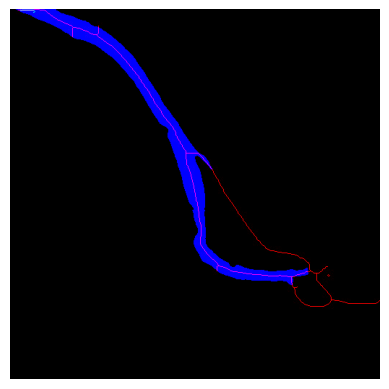

In [62]:
plt.imshow(np.stack([w_map, canvas, mask], axis=-1))
plt.axis('off')

In [79]:
pwd

'E:\\river_seg\\airc'

In [86]:
image = cv2.imread("data/v2/2015.png", cv2.IMREAD_UNCHANGED)
cv2.imwrite("data/v2/2015_rgb.png", image[...,:3])

True

In [85]:
image?

Type:        ndarray
String form:
[[[22 49 21  0]
           [26 52 22  0]
           [35 61 29  0]
           ...
           [30 55 52  0]
           [31 57 55  0]
           [32 58 57 <...> 66 90  0]
           [44 63 82  0]
           [41 64 80  0]
           ...
           [56 78 79  0]
           [58 78 79  0]
           [54 75 77  0]]]
Length:      6217
File:        e:\river_seg\venv\lib\site-packages\numpy\__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`

In [61]:
np.linspace(0, 1, num=51).tolist()

[0.0,
 0.02,
 0.04,
 0.06,
 0.08,
 0.1,
 0.12,
 0.14,
 0.16,
 0.18,
 0.2,
 0.22,
 0.24,
 0.26,
 0.28,
 0.3,
 0.32,
 0.34,
 0.36,
 0.38,
 0.4,
 0.42,
 0.44,
 0.46,
 0.48,
 0.5,
 0.52,
 0.54,
 0.56,
 0.58,
 0.6,
 0.62,
 0.64,
 0.66,
 0.68,
 0.7000000000000001,
 0.72,
 0.74,
 0.76,
 0.78,
 0.8,
 0.8200000000000001,
 0.84,
 0.86,
 0.88,
 0.9,
 0.92,
 0.9400000000000001,
 0.96,
 0.98,
 1.0]